In [1]:
import kagglehub


path = kagglehub.dataset_download("ming666/flicker8k-dataset")
print("✅ Dataset downloaded to:", path)


✅ Dataset downloaded to: /kaggle/input/flicker8k-dataset


In [2]:
import os
import glob


images_path = glob.glob(os.path.join(path, '**', 'Flicker8k_Dataset'), recursive=True)
captions_file = glob.glob(os.path.join(path, '**', 'Flickr8k.token.txt'), recursive=True)

if images_path and captions_file:
    images_path = images_path[0]
    captions_file = captions_file[0]
    print("✅ Images found at:", images_path)
    print("✅ Captions found at:", captions_file)
else:
    raise FileNotFoundError("❌ Image folder or captions file not found. Check dataset contents.")


✅ Images found at: /kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset
✅ Captions found at: /kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt


In [3]:
import string

def load_clean_descriptions(captions_file):
    with open(captions_file, 'r') as file:
        lines = file.readlines()

    descriptions = {}
    for line in lines:
        tokens = line.strip().split('\t')
        if len(tokens) != 2:
            continue
        image_id, caption = tokens[0].split('#')[0], tokens[1].lower()
        caption = caption.translate(str.maketrans('', '', string.punctuation))
        caption = ' '.join([w for w in caption.split() if w.isalpha()])
        caption = 'startseq ' + caption + ' endseq'

        if image_id not in descriptions:
            descriptions[image_id] = []
        descriptions[image_id].append(caption)

    return descriptions

descriptions = load_clean_descriptions(captions_file)
print(f"✅ Cleaned descriptions loaded for {len(descriptions)} images")


✅ Cleaned descriptions loaded for 8092 images


In [4]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
import numpy as np
from tqdm import tqdm


base_model = InceptionV3(weights='imagenet')
model_cnn = Model(base_model.input, base_model.layers[-2].output)

def extract_features(directory):
    features = {}
    for filename in tqdm(os.listdir(directory)):
        if not filename.lower().endswith(".jpg"):
            continue
        img_path = os.path.join(directory, filename)
        image = load_img(img_path, target_size=(299, 299))
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)
        image = preprocess_input(image)
        feature = model_cnn.predict(image, verbose=0)
        features[filename] = feature
    return features

features = extract_features(images_path)
print(f"✅ Extracted features for {len(features)} images")


96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


100%|██████████| 8091/8091 [51:33<00:00,  2.62it/s]

✅ Extracted features for 8091 images


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer


all_desc = []
for desc_list in descriptions.values():
    all_desc.extend(desc_list)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_desc)
vocab_size = len(tokenizer.word_index) + 1
print("✅ Vocabulary size:", vocab_size)


max_length = max(len(d.split()) for d in all_desc)
print("✅ Max sequence length:", max_length)


✅ Vocabulary size: 8778
✅ Max sequence length: 37


In [9]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

def create_sequences(tokenizer, max_length, descriptions, features, vocab_size):
    X1, X2, y = [], [], []
    for key, desc_list in descriptions.items():

        image_filename = key + '.jpg'
        if image_filename not in features:

            continue
        for desc in desc_list:
            seq = tokenizer.texts_to_sequences([desc])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(features[image_filename][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

X1, X2, y = create_sequences(tokenizer, max_length, descriptions, features, vocab_size)
print("✅ Training samples created:", X1.shape[0])

✅ Training samples created: 0


In [12]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import Model

# Image feature extractor
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Caption processor
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Decoder
decoder = add([fe2, se3])
decoder = Dense(256, activation='relu')(decoder)
outputs = Dense(vocab_size, activation='softmax')(decoder)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()



Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 37, 256)   │  2,247,168 │ input_layer_10[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 37, 256)   │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 37)        │          0 │ input_layer_10[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    525,312 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 8778)      │  2,255,946 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,618,762 (21.43 MB)

 Trainable params: 5,618,762 (21.43 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq', '').replace('endseq', '').strip()


📝 Generated Caption: flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops flops


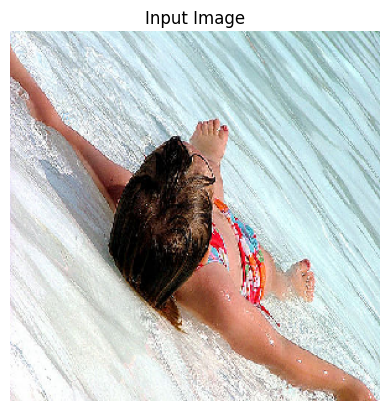

In [14]:
import matplotlib.pyplot as plt
from PIL import Image

test_image = os.path.join(images_path, '667626_18933d713e.jpg')
img = load_img(test_image, target_size=(299, 299))
plt.imshow(img)
plt.axis('off')
plt.title("Input Image")

image = img_to_array(img)
image = np.expand_dims(image, axis=0)
image = preprocess_input(image)

feature = model_cnn.predict(image, verbose=0)
caption = generate_caption(model, tokenizer, feature, max_length)

print("📝 Generated Caption:", caption)
